<a href="https://colab.research.google.com/github/omarseleem92/flood_susceptibility_mapping/blob/main/RF_2m.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pandas
## import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import geopandas as gpd

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 46.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 8.3 MB/s eta 0:00:00:00:01


In [2]:
# Read the shapefile
# Flooded = 0 indicates not flooded location while Flooded = 1 indicates flooded location
## Every location has values for the 11 flood predictory features.
df=gpd.read_file("points_data.shp") #("/content/drive/MyDrive/RF_model_Flood_susceptibility/Merged_RF.shp")
df.head()

,id,label,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text,geometry
0,0,0,810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7,POINT (648355.689 1032128.503)
1,1,0,798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7,POINT (652338.758 1039898.468)
2,2,0,783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7,POINT (654594.349 1045368.461)
3,3,0,845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7,POINT (653891.492 1031276.320)
4,4,0,803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7,POINT (657859.303 1042542.024)


In [3]:
df = df.drop(labels = ["id"], axis=1) 

In [4]:
print(df.describe().T)  #Values are already normalized in GIS before fitting. 

           count          mean           std           min         25%  \
label      393.0  6.921120e-01  4.622084e-01  0.000000e+00    0.000000   
DEM        393.0  7.298244e+02  4.759590e+01  6.960000e+02  706.000000   
Slope      393.0  4.342038e+00  5.112538e+00  0.000000e+00    1.811248   
Aspect     393.0 -7.185369e+02  2.907206e+03 -9.999000e+03   71.565048   
Curvature  393.0  7.002544e-02  8.639245e-01 -2.560000e+00   -0.640000   
Soil_Test  393.0  0.000000e+00  0.000000e+00  0.000000e+00    0.000000   
CN         393.0  6.035623e+01  1.044618e+01  3.000000e+01   58.000000   
TWI        393.0 -1.731717e+20  2.424395e+21 -3.402823e+22    6.958297   
Rainfall   393.0  1.191060e+01  2.368298e+00  6.662645e+00   10.237988   
LULC       393.0  4.208651e+01  2.634587e+01  2.000000e+01   20.000000   
Soil_Text  393.0  4.175573e+00  1.418613e+00  1.000000e+00    4.000000   

                  50%         75%          max  
label        1.000000    1.000000     1.000000  
DEM        71

In [5]:
## Check if there is null values
print(df.isnull().sum())
#df = df.dropna()

label        0
DEM          0
Slope        0
Aspect       0
Curvature    0
Soil_Test    0
CN           0
TWI          0
Rainfall     0
LULC         0
Soil_Text    0
geometry     0
dtype: int64


<Axes: xlabel='label', ylabel='count'>

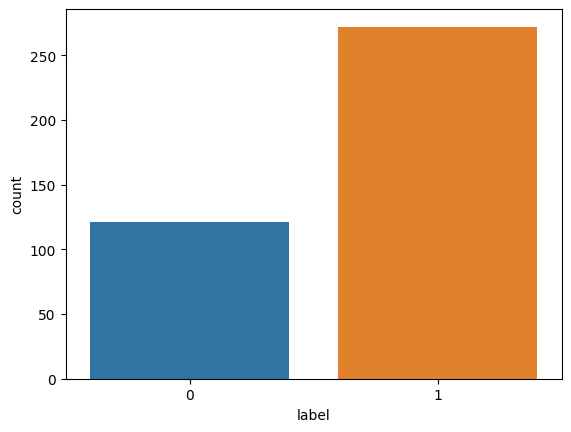

In [6]:
#Understand the data 
# The dataset includes the same number of flooded and not flooded locations
sns.countplot(x="label", data=df) #0 - Notflooded   1 - Flooded

<Axes: >

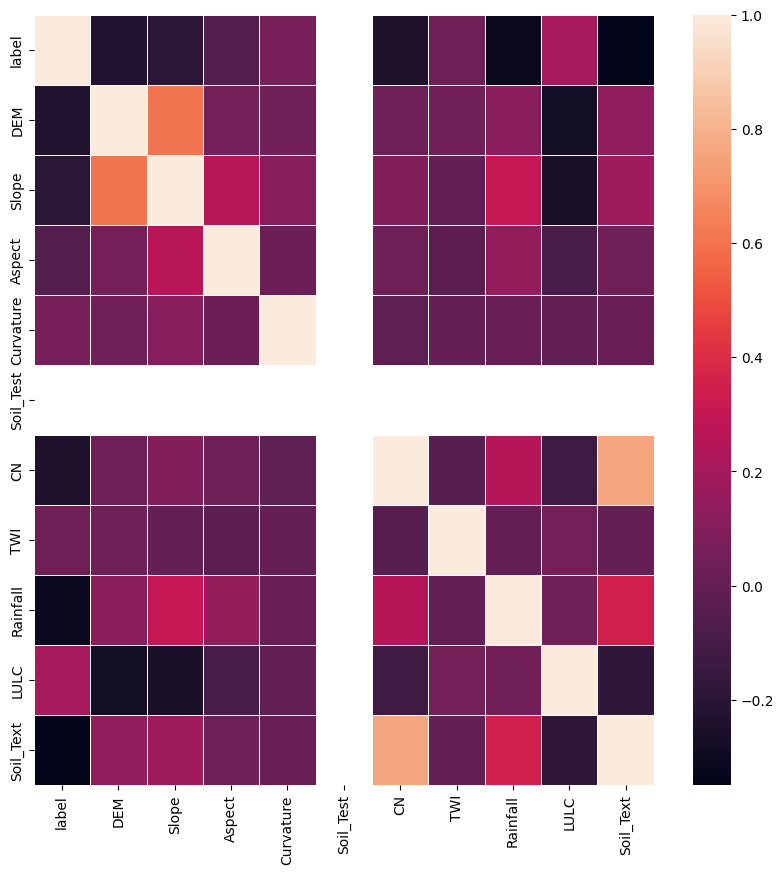

In [7]:
# Correlation between the input features
# plt.show()
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Compute the correlation matrix
corrMatrix = numeric_df.corr()

# Now you can create the heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, annot=False, linewidths=.5, ax=ax)

In [8]:
#Define the dependent variable that needs to be predicted (labels)
Y = df["label"].values


In [9]:
#Define the independent variables. 
X = df.drop(labels = ['label','Soil_Test','geometry'], axis=1) 
features_list = list(X.columns)  #List features so we can rank them later.
#from sklearn.preprocessing import normalize
# Only needed if the data was not normalized
#X = normalize(X, axis=1)

In [10]:
# the independent variables
X

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7
1,798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7
2,783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7
3,845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7
4,803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7
...,...,...,...,...,...,...,...,...,...
388,719,0.000000,-9999.000000,-0.00,30,9.554776,10.237988,90,1
389,720,1.811248,161.565048,-0.64,30,6.938687,10.237988,30,1
390,721,0.000000,-9999.000000,-0.00,58,7.469123,10.237988,40,4
391,715,0.000000,-9999.000000,-0.00,58,14.062859,14.165248,90,4


In [11]:
# the dependent variable
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [12]:
#Split data into train, validation and test to verify accuracy after fitting the model. 
# Firstly split the data into train_validation and test datasets then split the train_validation dataset into train and validation datasets.
# The training dataset is used to train the model, the validation dataset is used for hyperparamter tuning and the testing dataset is used to test the model.
# It is recommended to test the model with a data that the model hasn't seen in the training process
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, Y, test_size=0.2,shuffle=True, random_state=124)


In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25,shuffle=True, random_state=124)

In [14]:
#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state = 124)

In [15]:
# Train the model on training data
model.fit(X_train, y_train)

RandomForestClassifier(random_state=124)

In [16]:
# Model prediction
prediction = model.predict(X_test)

In [17]:
# Prediction are 1 (Flooded) and 0 (Not flooded)
prediction 

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

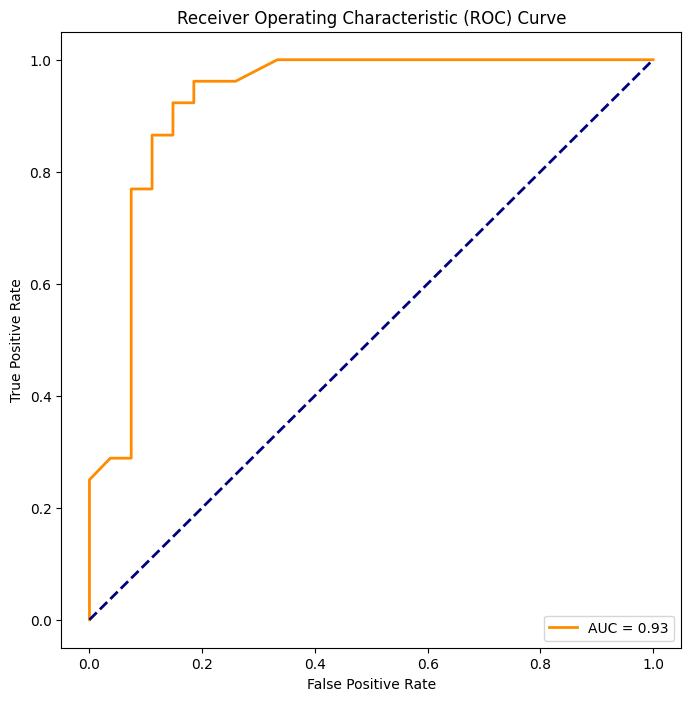

In [18]:
# Draw the Receiver Operating Characteristics and estimate the Area under the curve (AUC)
# for more information about the AUC, please see https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have a trained classifier named 'model'
y_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [19]:
# In order to map the flood susceptibility, we need to predict the flood susceptibility (probability between 0 and 1)
prediction_prob=model.predict_proba(X_test)

In [20]:
# The probability of being not flooded and flooded for every location ( Their summation equals 1)
prediction_prob

array([[0.13, 0.87],
       [0.01, 0.99],
       [0.48, 0.52],
       [0.3 , 0.7 ],
       [0.53, 0.47],
       [0.55, 0.45],
       [0.13, 0.87],
       [0.01, 0.99],
       [0.31, 0.69],
       [0.01, 0.99],
       [0.06, 0.94],
       [0.42, 0.58],
       [0.01, 0.99],
       [0.13, 0.87],
       [0.03, 0.97],
       [0.87, 0.13],
       [0.02, 0.98],
       [0.06, 0.94],
       [0.07, 0.93],
       [0.75, 0.25],
       [0.06, 0.94],
       [0.3 , 0.7 ],
       [0.43, 0.57],
       [0.01, 0.99],
       [0.02, 0.98],
       [0.1 , 0.9 ],
       [0.08, 0.92],
       [0.53, 0.47],
       [0.49, 0.51],
       [0.79, 0.21],
       [0.01, 0.99],
       [0.09, 0.91],
       [0.25, 0.75],
       [0.63, 0.37],
       [0.61, 0.39],
       [0.13, 0.87],
       [0.92, 0.08],
       [0.57, 0.43],
       [0.05, 0.95],
       [0.21, 0.79],
       [0.68, 0.32],
       [0.02, 0.98],
       [0.1 , 0.9 ],
       [0.02, 0.98],
       [0.64, 0.36],
       [0.07, 0.93],
       [0.69, 0.31],
       [0.12,

In [21]:
ls=prediction_prob[:,1]
ls.shape

(79,)

In [22]:
# As flood susceptibility is classification problem (flooded or not flooded), we can calculate some additional performance indices
from sklearn.metrics import classification_report
target_names=["Not Flooded","Flooded"]
print(classification_report(y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

 Not Flooded       0.91      0.74      0.82        27
     Flooded       0.88      0.96      0.92        52

    accuracy                           0.89        79
   macro avg       0.89      0.85      0.87        79
weighted avg       0.89      0.89      0.88        79



In [23]:
from sklearn.metrics import cohen_kappa_score
print(cohen_kappa_score(y_test, prediction))


0.7349981364144614


In [24]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction)
print(cm)

[[20  7]
 [ 2 50]]


In [25]:
#importances = list(model_RF.feature_importances_)
feature_imp = pd.Series(model.feature_importances_, index=features_list).sort_values(ascending=False)
print(feature_imp)

DEM          0.251496
TWI          0.159591
Slope        0.121618
Rainfall     0.120067
Aspect       0.107864
LULC         0.079109
CN           0.064601
Curvature    0.047902
Soil_Text    0.047752
dtype: float64


<Axes: >

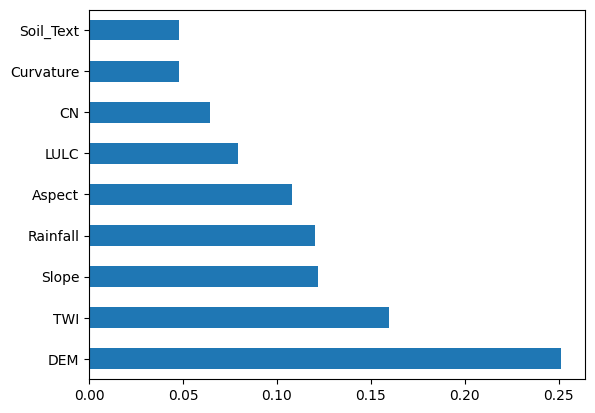

In [26]:
feature_imp.plot.barh()

# Amibara

In [27]:
!pip3 install pickle5
import pickle5 as pickle


Defaulting to user installation because normal site-packages is not writeable


In [28]:
with open('points_data.pkl', "rb") as fh:
  df = pickle.load(fh)


In [29]:
df.head()

,id,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text
0,0,0,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7
1,1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7
2,2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7
3,3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7
4,4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7


In [30]:
X_hotspot0= df.drop(labels = ["geometry",'id','label','Soil_Test'], axis=1) 
X_hotspot0.head()

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7
1,798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7
2,783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7
3,845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7
4,803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7


In [31]:
cols=X.columns
cols

Index(['DEM', 'Slope', 'Aspect', 'Curvature', 'CN', 'TWI', 'Rainfall', 'LULC',
       'Soil_Text'],
      dtype='object')

In [32]:
X_hotspot0=X_hotspot0[cols]
X_hotspot0.head()

,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text
0,810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7
1,798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7
2,783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7
3,845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7
4,803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7


In [33]:
print(X_hotspot0.isnull().sum())


DEM          0
Slope        0
Aspect       0
Curvature    0
CN           0
TWI          0
Rainfall     0
LULC         0
Soil_Text    0
dtype: int64


In [34]:
X_hotspot0 = X_hotspot0.dropna()

In [35]:
df=df.dropna()

In [36]:
prediction_prob=model.predict_proba(X_hotspot0)

In [37]:
prediction_prob

array([[0.87, 0.13],
       [0.96, 0.04],
       [0.96, 0.04],
       [0.93, 0.07],
       [0.94, 0.06],
       [0.92, 0.08],
       [0.93, 0.07],
       [0.86, 0.14],
       [0.98, 0.02],
       [0.86, 0.14],
       [0.95, 0.05],
       [0.63, 0.37],
       [0.5 , 0.5 ],
       [0.94, 0.06],
       [0.71, 0.29],
       [0.81, 0.19],
       [0.03, 0.97],
       [0.76, 0.24],
       [0.91, 0.09],
       [0.98, 0.02],
       [0.96, 0.04],
       [0.75, 0.25],
       [0.81, 0.19],
       [0.79, 0.21],
       [0.69, 0.31],
       [0.91, 0.09],
       [0.99, 0.01],
       [0.71, 0.29],
       [0.96, 0.04],
       [0.81, 0.19],
       [0.84, 0.16],
       [0.68, 0.32],
       [0.77, 0.23],
       [0.42, 0.58],
       [0.22, 0.78],
       [0.05, 0.95],
       [0.94, 0.06],
       [0.63, 0.37],
       [0.68, 0.32],
       [0.31, 0.69],
       [0.91, 0.09],
       [0.82, 0.18],
       [0.74, 0.26],
       [0.81, 0.19],
       [0.92, 0.08],
       [0.84, 0.16],
       [0.89, 0.11],
       [0.52,

In [38]:
ls_hotspot0=prediction_prob[:,1]
ls_hotspot0

array([0.13, 0.04, 0.04, 0.07, 0.06, 0.08, 0.07, 0.14, 0.02, 0.14, 0.05,
       0.37, 0.5 , 0.06, 0.29, 0.19, 0.97, 0.24, 0.09, 0.02, 0.04, 0.25,
       0.19, 0.21, 0.31, 0.09, 0.01, 0.29, 0.04, 0.19, 0.16, 0.32, 0.23,
       0.58, 0.78, 0.95, 0.06, 0.37, 0.32, 0.69, 0.09, 0.18, 0.26, 0.19,
       0.08, 0.16, 0.11, 0.48, 0.79, 0.33, 0.28, 0.26, 0.54, 0.21, 0.6 ,
       0.23, 0.22, 0.18, 0.36, 0.31, 0.16, 0.19, 0.07, 0.22, 0.4 , 0.51,
       0.13, 0.18, 0.15, 0.14, 0.11, 0.  , 0.52, 0.18, 0.12, 0.14, 0.03,
       0.27, 0.17, 0.19, 0.22, 0.17, 0.36, 0.04, 0.11, 0.02, 0.14, 0.43,
       0.23, 0.12, 0.17, 0.06, 0.17, 0.21, 0.13, 0.05, 0.34, 0.47, 0.39,
       0.2 , 0.47, 0.45, 0.07, 0.03, 0.  , 0.24, 0.3 , 0.13, 0.13, 0.04,
       0.1 , 0.26, 0.26, 0.4 , 0.28, 0.15, 0.19, 0.69, 0.78, 0.39, 0.68,
       0.88, 0.59, 0.99, 0.94, 0.72, 0.54, 0.9 , 0.73, 0.76, 0.82, 0.84,
       0.86, 0.89, 0.8 , 0.97, 0.89, 0.74, 0.48, 0.57, 0.94, 0.85, 0.79,
       0.62, 0.74, 0.91, 0.97, 0.73, 0.82, 0.52, 0.

In [39]:
df['FSM']=ls_hotspot0
df.head()


,id,label,geometry,DEM,Slope,Aspect,Curvature,Soil_Test,CN,TWI,Rainfall,LULC,Soil_Text,FSM
0,0,0,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,0,71,7.651444,8.634620,30,7,0.13
1,1,0,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,0,71,6.457982,9.113000,30,7,0.04
2,2,0,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,0,71,8.626627,14.380471,30,7,0.04
3,3,0,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,0,71,11.018336,9.009209,30,7,0.07
4,4,0,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,0,71,7.151129,11.598495,30,7,0.06


In [40]:
df= df.drop(labels = ['id','label','Soil_Test'], axis=1) 
df.head()

,geometry,DEM,Slope,Aspect,Curvature,CN,TWI,Rainfall,LULC,Soil_Text,FSM
0,POINT (648355.689 1032128.503),810,4.124518,56.309933,1.28,71,7.651444,8.634620,30,7,0.13
1,POINT (652338.758 1039898.468),798,1.811248,288.434937,-0.64,71,6.457982,9.113000,30,7,0.04
2,POINT (654594.349 1045368.461),783,2.429397,45.000000,-1.28,71,8.626627,14.380471,30,7,0.04
3,POINT (653891.492 1031276.320),845,0.810231,225.000000,-0.00,71,11.018336,9.009209,30,7,0.07
4,POINT (657859.303 1042542.024),803,1.811248,108.434952,-0.64,71,7.151129,11.598495,30,7,0.06


In [41]:
! pip install geocube

Defaulting to user installation because normal site-packages is not writeable


In [52]:
# %matplotlib inline

# import geocube
# from geocube.api.core import make_geocube

# geo_grid = make_geocube(
#     vector_data=df,
#     # measurements=['FSM'],
#     resolution=(-12.5, 12.5)
# )

In [53]:
# geo_grid.FSM.plot()

In [54]:
# import matplotlib.pyplot as plt

# # Set the backend to inline for Jupyter Notebook
# %matplotlib inline

# Plot the 'FSM' measurement directly from the GeoCube
# geo_grid.FSM.plot(cmap='viridis')  # Adjust the colormap as needed
# plt.title('FSM Measurement')
# plt.show()

In [49]:
geo_grid.FSM.rio.to_raster("FSM.tif")


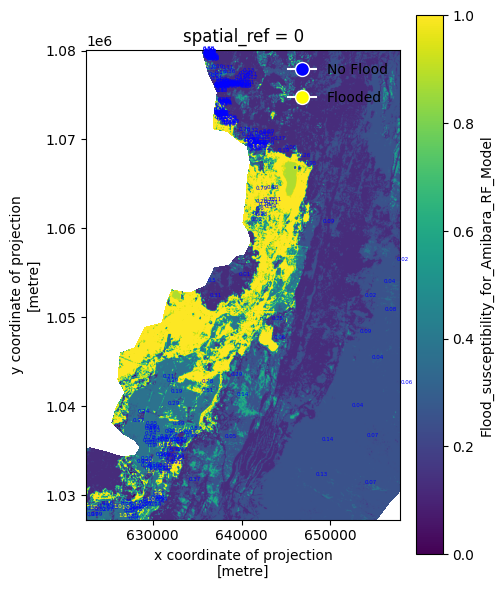

In [51]:
import geocube
from geocube.api.core import make_geocube
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import box
import rasterio
from rasterio.plot import show

# Assuming df is a GeoDataFrame with your vector data

# Create a GeoCube
geo_grid = make_geocube(
    vector_data=df,
    measurements=['FSM'],
    resolution=(-12.5, 12.5)
)

# Extract the raster data
raster_data = geo_grid.compute()

# Assuming LULC.tif is your LULC raster file with RGB values
lulc_path = "LULC.tif"
lulc_data = rasterio.open(lulc_path)

# Plot the raster data on a map
fig, ax = plt.subplots(figsize=(5, 7))  # Adjust the size of the map

# Assuming the raster_data is a DataArray with the 'label' variable
im1 = raster_data.FSM.plot(ax=ax, cmap='viridis', add_colorbar=False)

# Optionally, overlay your vector data on the map
#df.plot(ax=ax, color='yellow', alpha=0.5, edgecolor='black')

# Add labels for points
for idx, row in df.iterrows():
    color = 'yellow' if row['FSM'] == 1 else 'blue'
    ax.text(row.geometry.x, row.geometry.y, str(row['FSM']), color=color, fontsize=4)

# Add legends for flood and no flood with distinct colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10),
                  plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=10)]
legend_labels = {0: 'No Flood', 1: 'Flooded'}
ax.legend(legend_handles, legend_labels.values(), scatterpoints=1, frameon=False, labelspacing=1, loc='upper right')

# Show the LULC raster with RGB values
show(lulc_data, ax=ax)

# Add default legends for the raster data
cbar = plt.colorbar(im1, ax=ax, pad=0.04)
cbar.set_label('Flood_susceptibility_for_Amibara_RF_Model')

# # Set the legend ticks and labels
# cbar.set_ticks([0, 1])
# cbar.set_ticklabels(['Min', 'Max'])

# # Adjust the extent of the map
# ax.set_xlim(lulc_data.bounds.left.min(), lulc_data.bounds.right.max())
# ax.set_ylim(lulc_data.bounds.bottom.min(), lulc_data.bounds.top.max())

# Show the map
plt.show()